 Leprosy Image Generation

About Chagas disease


#Setup
* Numpy and Tensorflow for Mathematical Operations
* Matplotlib and OpenCV for Image data handling and Visualization
* Keras for the Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
MAIN_DIR = "//content/drive/MyDrive/DoutoradoInatel/Collabs_IA_IoT/Hans2_app/CO2wounds/split/train"

In [4]:
NOISE_DIM = 100
BATCH_SIZE = 4
STEPS_PER_EPOCH = 200
EPOCHS = 10 # Keeping the same number of epochs for now
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 3

OPTIMIZER = Adam(0.0002, 0.5)

#Loading and Preprocessing the images

In [5]:
def load_images(folder):

    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir, cv2.IMREAD_COLOR) # Explicitly read as color
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
            img = cv2.resize(img, (128,128))
            img = img.astype(np.float32) / 255.0 # Scale to 0-1 range and convert to float32
            imgs.append(img)
            labels.append(target)
        except:
            continue

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

In [6]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((525, 128, 128, 3), (525,))

#Generate 20 random numbers to index image from data

In [7]:
np.random.seed(SEED)
idxs = np.random.randint(0, data.shape[0], size=40)

In [8]:
X_train = data[idxs]
X_train.shape

(40, 128, 128, 3)

#Normalize and Reshape the data

In [9]:
# Normalize the Images - Removed as scaling is done in load_images
# X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape

(40, 128, 128, 3)

#Plot the real images

In [10]:
plt.figure(figsize=(20,8))
for i in range(X_train.shape[0]):
    axs = plt.subplot(5,8,i+1) # Changed to 4x5 grid
    plt.imshow(X_train[i])
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

#The architecture

In [11]:
def build_generator():

    """
        Generator model "generates" images using random noise. The random noise AKA Latent Vector
        is sampled from a Normal Distribution which is given as the input to the Generator. Using
        Transposed Convolution, the latent vector is transformed to produce an image
        We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
        of Convolutional Learning)

        Input: Random Noise / Latent Vector
        Output: Image
    """

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ],
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [12]:
def build_discriminator():

    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

#Putting it together

In [13]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        65,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 583,937 (2.23 MB)

 Trainable params: 583,937 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 262144)         │    26,476,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 128)  │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,269,379 (104.02 MB)

 Trainable params: 27,269,379 (104.02 MB)

 Non-trainable params: 0 (0.00 B)

The Combined Network:



Model: "gan_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator (Sequential)          │ (None, 128, 128, 3)    │    27,269,379 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Sequential)      │ (None, 1)              │       583,937 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,853,316 (106.25 MB)

 Trainable params: 27,269,379 (104.02 MB)

 Non-trainable params: 583,937 (2.23 MB)

In [14]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    # Rescale images from [-1, 1] to [0, 1] for plotting
    generated_images = 0.5 * generated_images + 0.5
    plt.figure(figsize=figsize)

    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')

        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#The training

Epoch 1/10


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


  0%|          | 1/200 [00:05<16:58,  5.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


  1%|          | 2/200 [00:10<17:17,  5.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  2%|▏         | 3/200 [00:13<13:54,  4.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


  2%|▏         | 4/200 [00:16<12:33,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


  2%|▎         | 5/200 [00:20<11:51,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


  3%|▎         | 6/200 [00:24<12:41,  3.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


  4%|▎         | 7/200 [00:28<12:20,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  4%|▍         | 8/200 [00:32<12:56,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


  4%|▍         | 9/200 [00:36<12:48,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


  5%|▌         | 10/200 [00:41<13:52,  4.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  6%|▌         | 11/200 [00:45<12:46,  4.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  6%|▌         | 12/200 [00:48<11:42,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  6%|▋         | 13/200 [00:51<11:09,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


  7%|▋         | 14/200 [00:55<11:49,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


  8%|▊         | 15/200 [00:59<11:47,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


  8%|▊         | 16/200 [01:02<11:15,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


  8%|▊         | 17/200 [01:06<10:51,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  9%|▉         | 18/200 [01:10<11:48,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 10%|▉         | 19/200 [01:14<11:15,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 10%|█         | 20/200 [01:17<10:32,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 10%|█         | 21/200 [01:20<10:14,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 11%|█         | 22/200 [01:24<11:00,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 12%|█▏        | 23/200 [01:28<10:52,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 12%|█▏        | 24/200 [01:31<10:26,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 12%|█▎        | 25/200 [01:34<10:06,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 13%|█▎        | 26/200 [01:38<10:34,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 14%|█▎        | 27/200 [01:42<10:42,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 14%|█▍        | 28/200 [01:46<10:17,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 14%|█▍        | 29/200 [01:49<09:46,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 15%|█▌        | 30/200 [01:53<10:24,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 16%|█▌        | 31/200 [01:57<10:32,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 16%|█▌        | 32/200 [02:00<10:02,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 16%|█▋        | 33/200 [02:03<09:42,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 17%|█▋        | 34/200 [02:08<10:30,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 18%|█▊        | 35/200 [02:12<10:34,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 18%|█▊        | 36/200 [02:15<09:51,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 18%|█▊        | 37/200 [02:18<09:28,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 19%|█▉        | 38/200 [02:23<10:20,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 20%|█▉        | 39/200 [02:26<09:52,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 20%|██        | 40/200 [02:29<09:28,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 20%|██        | 41/200 [02:32<09:00,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 21%|██        | 42/200 [02:36<09:29,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 22%|██▏       | 43/200 [02:40<09:39,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 22%|██▏       | 44/200 [02:43<09:03,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 22%|██▎       | 45/200 [02:47<08:48,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 23%|██▎       | 46/200 [02:51<09:28,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 24%|██▎       | 47/200 [02:55<09:22,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 24%|██▍       | 48/200 [02:58<08:58,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 24%|██▍       | 49/200 [03:01<08:32,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 25%|██▌       | 50/200 [03:05<08:44,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 26%|██▌       | 51/200 [03:09<09:09,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 26%|██▌       | 52/200 [03:12<08:36,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 26%|██▋       | 53/200 [03:15<08:12,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 27%|██▋       | 54/200 [03:18<08:20,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 28%|██▊       | 55/200 [03:23<08:54,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 28%|██▊       | 56/200 [03:26<08:33,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 28%|██▊       | 57/200 [03:29<08:15,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 29%|██▉       | 58/200 [03:33<08:35,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 30%|██▉       | 59/200 [03:37<08:43,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 30%|███       | 60/200 [03:40<08:20,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 30%|███       | 61/200 [03:43<07:53,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 31%|███       | 62/200 [03:47<08:04,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 32%|███▏      | 63/200 [03:51<08:36,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 32%|███▏      | 64/200 [03:55<08:12,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 32%|███▎      | 65/200 [03:58<07:55,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 33%|███▎      | 66/200 [04:02<08:11,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 34%|███▎      | 67/200 [04:06<08:18,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 34%|███▍      | 68/200 [04:09<07:54,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 34%|███▍      | 69/200 [04:12<07:36,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 35%|███▌      | 70/200 [04:16<07:43,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 36%|███▌      | 71/200 [04:21<08:11,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 36%|███▌      | 72/200 [04:24<07:47,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 36%|███▋      | 73/200 [04:27<07:27,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 37%|███▋      | 74/200 [04:31<07:44,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 38%|███▊      | 75/200 [04:35<07:52,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 38%|███▊      | 76/200 [04:38<07:22,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 38%|███▊      | 77/200 [04:42<07:08,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 39%|███▉      | 78/200 [04:45<07:07,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 40%|███▉      | 79/200 [04:49<07:31,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 40%|████      | 80/200 [04:53<07:11,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 40%|████      | 81/200 [04:56<06:49,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 41%|████      | 82/200 [04:59<06:37,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 42%|████▏     | 83/200 [05:04<07:23,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 42%|████▏     | 84/200 [05:07<07:02,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 42%|████▎     | 85/200 [05:10<06:44,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 43%|████▎     | 86/200 [05:14<06:46,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 44%|████▎     | 87/200 [05:18<07:13,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 44%|████▍     | 88/200 [05:22<06:48,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 44%|████▍     | 89/200 [05:25<06:27,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 45%|████▌     | 90/200 [05:29<06:36,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 46%|████▌     | 91/200 [05:33<06:55,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 46%|████▌     | 92/200 [05:36<06:33,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 46%|████▋     | 93/200 [05:39<06:16,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 47%|████▋     | 94/200 [05:43<06:26,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 48%|████▊     | 95/200 [05:47<06:34,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 48%|████▊     | 96/200 [05:50<06:07,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 48%|████▊     | 97/200 [05:53<05:49,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 49%|████▉     | 98/200 [05:57<05:53,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 50%|████▉     | 99/200 [06:01<06:07,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 50%|█████     | 100/200 [06:04<05:48,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 50%|█████     | 101/200 [06:07<05:37,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 51%|█████     | 102/200 [06:11<05:37,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 52%|█████▏    | 103/200 [06:16<06:07,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 52%|█████▏    | 104/200 [06:19<05:48,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 52%|█████▎    | 105/200 [06:22<05:35,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 53%|█████▎    | 106/200 [06:26<05:45,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 54%|█████▎    | 107/200 [06:30<05:55,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 54%|█████▍    | 108/200 [06:34<05:36,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 55%|█████▍    | 109/200 [06:37<05:21,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 55%|█████▌    | 110/200 [06:41<05:36,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 56%|█████▌    | 111/200 [06:45<05:38,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 56%|█████▌    | 112/200 [06:48<05:13,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 56%|█████▋    | 113/200 [06:51<05:01,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 57%|█████▋    | 114/200 [06:56<05:23,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 57%|█████▊    | 115/200 [06:59<05:14,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 58%|█████▊    | 116/200 [07:02<04:58,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 58%|█████▊    | 117/200 [07:06<04:46,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 59%|█████▉    | 118/200 [07:10<04:59,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 60%|█████▉    | 119/200 [07:14<05:05,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 60%|██████    | 120/200 [07:17<04:43,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 60%|██████    | 121/200 [07:20<04:26,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 61%|██████    | 122/200 [07:24<04:34,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 62%|██████▏   | 123/200 [07:28<04:43,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 62%|██████▏   | 124/200 [07:31<04:24,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 62%|██████▎   | 125/200 [07:34<04:16,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 63%|██████▎   | 126/200 [07:38<04:31,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 64%|██████▎   | 127/200 [07:42<04:34,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 64%|██████▍   | 128/200 [07:45<04:15,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 64%|██████▍   | 129/200 [07:48<04:00,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 65%|██████▌   | 130/200 [07:52<04:07,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 66%|██████▌   | 131/200 [07:56<04:14,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 66%|██████▌   | 132/200 [07:59<04:01,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 66%|██████▋   | 133/200 [08:03<03:52,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 67%|██████▋   | 134/200 [08:07<04:03,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 68%|██████▊   | 135/200 [08:11<04:04,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 68%|██████▊   | 136/200 [08:14<03:48,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 68%|██████▊   | 137/200 [08:17<03:36,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 69%|██████▉   | 138/200 [08:21<03:47,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 70%|██████▉   | 139/200 [08:25<03:42,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 70%|███████   | 140/200 [08:28<03:32,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 70%|███████   | 141/200 [08:31<03:19,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 71%|███████   | 142/200 [08:35<03:23,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 72%|███████▏  | 143/200 [08:39<03:29,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 72%|███████▏  | 144/200 [08:42<03:19,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 72%|███████▎  | 145/200 [08:46<03:11,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 73%|███████▎  | 146/200 [08:50<03:18,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 74%|███████▎  | 147/200 [08:54<03:19,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 74%|███████▍  | 148/200 [08:57<03:08,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 74%|███████▍  | 149/200 [09:00<02:56,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 75%|███████▌  | 150/200 [09:05<03:11,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 76%|███████▌  | 151/200 [09:09<03:09,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 76%|███████▌  | 152/200 [09:12<02:57,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 76%|███████▋  | 153/200 [09:15<02:45,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 77%|███████▋  | 154/200 [09:20<02:58,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 78%|███████▊  | 155/200 [09:23<02:44,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 78%|███████▊  | 156/200 [09:26<02:32,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 78%|███████▊  | 157/200 [09:29<02:26,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 79%|███████▉  | 158/200 [09:34<02:34,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 80%|███████▉  | 159/200 [09:38<02:33,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 80%|████████  | 160/200 [09:41<02:21,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 80%|████████  | 161/200 [09:44<02:12,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 81%|████████  | 162/200 [09:48<02:21,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 82%|████████▏ | 163/200 [09:52<02:19,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 82%|████████▏ | 164/200 [09:55<02:11,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 82%|████████▎ | 165/200 [09:59<02:03,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 83%|████████▎ | 166/200 [10:03<02:10,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 84%|████████▎ | 167/200 [10:06<02:00,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 84%|████████▍ | 168/200 [10:10<01:51,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 84%|████████▍ | 169/200 [10:13<01:46,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 85%|████████▌ | 170/200 [10:17<01:53,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 86%|████████▌ | 171/200 [10:21<01:46,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 86%|████████▌ | 172/200 [10:24<01:39,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 86%|████████▋ | 173/200 [10:27<01:33,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 87%|████████▋ | 174/200 [10:32<01:37,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 88%|████████▊ | 175/200 [10:36<01:35,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 88%|████████▊ | 176/200 [10:39<01:28,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 88%|████████▊ | 177/200 [10:42<01:21,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 89%|████████▉ | 178/200 [10:47<01:25,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 90%|████████▉ | 179/200 [10:50<01:17,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 90%|█████████ | 180/200 [10:54<01:11,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 90%|█████████ | 181/200 [10:57<01:06,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 91%|█████████ | 182/200 [11:02<01:09,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 92%|█████████▏| 183/200 [11:05<01:02,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 92%|█████████▏| 184/200 [11:08<00:56,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 92%|█████████▎| 185/200 [11:11<00:51,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 93%|█████████▎| 186/200 [11:16<00:53,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 94%|█████████▎| 187/200 [11:19<00:47,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 94%|█████████▍| 188/200 [11:22<00:41,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 94%|█████████▍| 189/200 [11:25<00:37,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 95%|█████████▌| 190/200 [11:30<00:36,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 96%|█████████▌| 191/200 [11:33<00:32,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 96%|█████████▌| 192/200 [11:36<00:27,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 96%|█████████▋| 193/200 [11:39<00:23,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 97%|█████████▋| 194/200 [11:43<00:21,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 98%|█████████▊| 195/200 [11:47<00:18,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 98%|█████████▊| 196/200 [11:50<00:13,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 98%|█████████▊| 197/200 [11:54<00:10,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 99%|█████████▉| 198/200 [11:58<00:07,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


100%|█████████▉| 199/200 [12:02<00:03,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


100%|██████████| 200/200 [12:05<00:00,  3.63s/it]


EPOCH: 1 Generator Loss: 0.3163 Discriminator Loss: 1.1025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


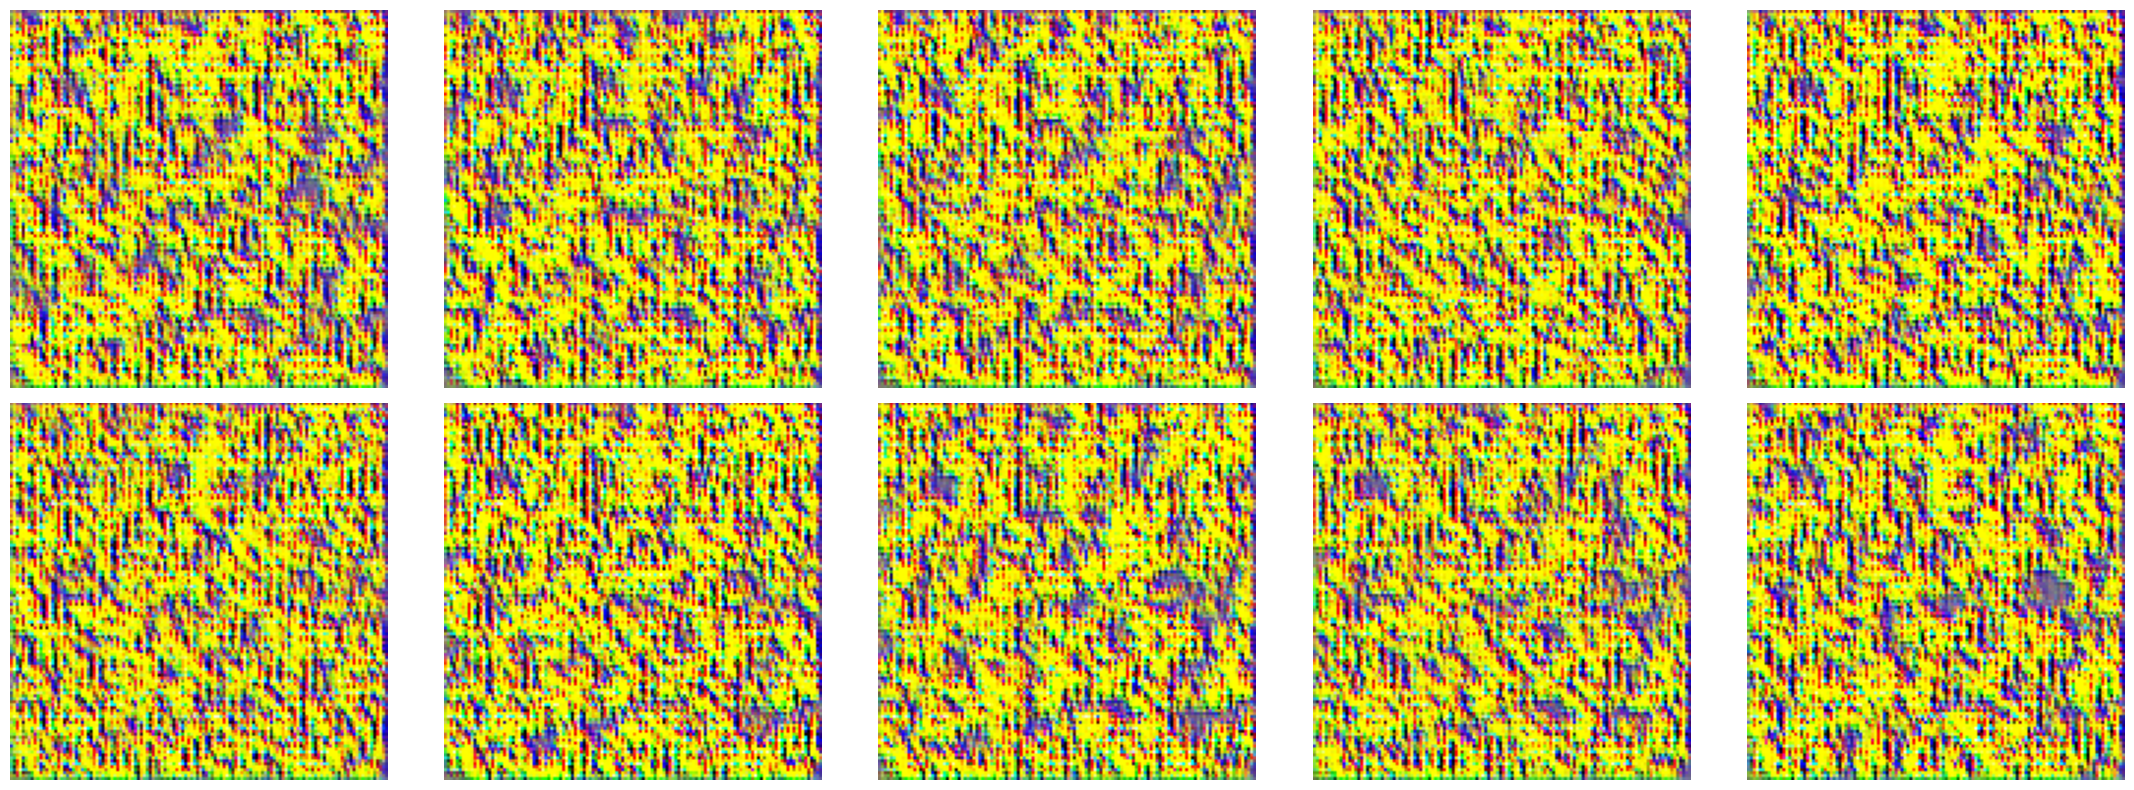

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
np.random.seed(SEED)
for epoch in range(10): # Changed range to 10 epochs
    # Display progress bar only for specified epochs
    if (epoch + 1) in [1, 5, 10]:
        print(f"Epoch {epoch + 1}/{10}") # Changed total epochs in print statement
        batch_iterator = tqdm(range(STEPS_PER_EPOCH))
    else:
        batch_iterator = range(STEPS_PER_EPOCH)

    for batch in batch_iterator:
        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)

        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)

        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    # Sample images only at specified epochs
    if (epoch + 1) in [1, 5, 10]:
        noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
        sample_images(noise, (2,5))

In [ ]:
#Generate some images
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

#Testing the generated sample and distribuutions plotting

In [ ]:
generated_images = generator.predict(noise)
generated_images.shape

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()